In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms,datasets
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import pandas as pd
from torch.utils.data import Dataset, DataLoader


In [2]:
np.random.seed(42)
torch.manual_seed(42)

In [3]:
class CustomDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data.iloc[idx, 1:].values.astype(np.uint8).reshape((28, 28,1))
        label = self.data.iloc[idx, 0]
        if self.transform:
            image = self.transform(image)
        return image, label

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.0,), (1.0,))])

train_set = CustomDataset(csv_file='mnist_train.csv', transform=transform)
test_set = CustomDataset(csv_file='mnist_test.csv', transform=transform)

train_set, val_set = torch.utils.data.random_split(train_set, [50000, 10000])
test_set = datasets.MNIST(root = './data', train=False, transform = transform, download=True)
train_loader = torch.utils.data.DataLoader(train_set,batch_size=1,shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set,batch_size=1,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set,batch_size=1,shuffle=True)

In [5]:
print("Training data:",len(train_loader),"Validation data:",len(val_loader),"Test data: ",len(test_loader))

Training data: 50000 Validation data: 10000 Test data:  10000


In [6]:
use_cuda=True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

In [7]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, 3, 1)
    self.conv2 = nn.Conv2d(32, 64, 3, 1)
    self.dropout1 = nn.Dropout(0.25)
    self.dropout2 = nn.Dropout(0.5)
    self.fc1 = nn.Linear(9216, 128)
    self.fc2 = nn.Linear(128, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = self.dropout1(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dropout2(x)
    x = self.fc2(x)
    output = F.log_softmax(x, dim=1)
    return output
     

In [8]:
model = Net().to(device)

In [9]:
optimizer = optim.Adam(model.parameters(),lr=0.0001, betas=(0.9, 0.999))
criterion = nn.NLLLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

In [10]:
def fit(model,device,train_loader,val_loader,epochs):
  data_loader = {'train':train_loader,'val':val_loader}
  print("Fitting the model...")
  train_loss,val_loss=[],[]
  for epoch in range(epochs):
    loss_per_epoch,val_loss_per_epoch=0,0
    for phase in ('train','val'):
      for i,data in enumerate(data_loader[phase]):
        input,label  = data[0].to(device),data[1].to(device)
        output = model(input)
        #calculating loss on the output
        loss = criterion(output,label)
        if phase == 'train':
          optimizer.zero_grad()
          #grad calc w.r.t Loss func
          loss.backward()
          #update weights
          optimizer.step()
          loss_per_epoch+=loss.item()
        else:
          val_loss_per_epoch+=loss.item()
    scheduler.step(val_loss_per_epoch/len(val_loader))
    print("Epoch: {} Loss: {} Val_Loss: {}".format(epoch+1,loss_per_epoch/len(train_loader),val_loss_per_epoch/len(val_loader)))
    train_loss.append(loss_per_epoch/len(train_loader))
    val_loss.append(val_loss_per_epoch/len(val_loader))
  return train_loss,val_loss
     

In [11]:
loss,val_loss=fit(model,device,train_loader,val_loader,10)

Fitting the model...
Epoch: 1 Loss: 0.2626793947649608 Val_Loss: 0.1264485823293552
Epoch: 2 Loss: 0.09891354136537799 Val_Loss: 0.10135390352183096
Epoch: 3 Loss: 0.08152076405444611 Val_Loss: 0.09728242842606878
Epoch: 4 Loss: 0.07546065175838407 Val_Loss: 0.09562679281446994
Epoch: 5 Loss: 0.0737181948257823 Val_Loss: 0.09629348345211196
Epoch: 6 Loss: 0.073493435359472 Val_Loss: 0.0941777473816964
Epoch: 7 Loss: 0.07407380703023679 Val_Loss: 0.08662147846837309
Epoch: 8 Loss: 0.07266524961707235 Val_Loss: 0.09526927734518124
Epoch: 9 Loss: 0.07325186941971455 Val_Loss: 0.0958588775671066
Epoch: 10 Loss: 0.07467707359408125 Val_Loss: 0.09001252748014749


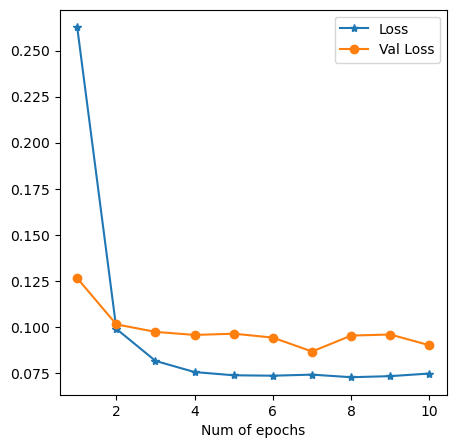

In [12]:
fig = plt.figure(figsize=(5,5))
plt.plot(np.arange(1,11), loss, "*-",label="Loss")
plt.plot(np.arange(1,11), val_loss,"o-",label="Val Loss")
plt.xlabel("Num of epochs")
plt.legend()
plt.show()
     

In [13]:
def fgsm_attack(input,epsilon,data_grad):
  pert_out = input + epsilon*data_grad.sign()
  pert_out = torch.clamp(pert_out, 0, 1)
  return pert_out

def ifgsm_attack(input,epsilon,data_grad):
  iter = 10
  alpha = epsilon/iter
  pert_out = input
  for i in range(iter-1):
    pert_out = pert_out + alpha*data_grad.sign()
    pert_out = torch.clamp(pert_out, 0, 1)
    if torch.norm((pert_out-input),p=float('inf')) > epsilon:
      break
  return pert_out

def mifgsm_attack(input,epsilon,data_grad):
  iter=10
  decay_factor=1.0
  pert_out = input
  alpha = epsilon/iter
  g=0
  for i in range(iter-1):
    g = decay_factor*g + data_grad/torch.norm(data_grad,p=1)
    pert_out = pert_out + alpha*torch.sign(g)
    pert_out = torch.clamp(pert_out, 0, 1)
    if torch.norm((pert_out-input),p=float('inf')) > epsilon:
      break
  return pert_out

In [14]:
def test(model,device,test_loader,epsilon,attack):
  correct = 0
  adv_examples = []
  for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      data.requires_grad = True
      output = model(data)
      init_pred = output.max(1, keepdim=True)[1] 
      if init_pred.item() != target.item():
          continue
      loss = F.nll_loss(output, target)
      model.zero_grad()
      loss.backward()
      data_grad = data.grad.data

      if attack == "fgsm":
        perturbed_data = fgsm_attack(data,epsilon,data_grad)
      elif attack == "ifgsm":
        perturbed_data = ifgsm_attack(data,epsilon,data_grad)
      elif attack == "mifgsm":
        perturbed_data = mifgsm_attack(data,epsilon,data_grad)
        
      output = model(perturbed_data)
      final_pred = output.max(1, keepdim=True)[1]
      if final_pred.item() == target.item():
          correct += 1
          if (epsilon == 0) and (len(adv_examples) < 5):
              adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
              adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
      else:
          if len(adv_examples) < 5:
              adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
              adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

  final_acc = correct/float(len(test_loader))
  print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

  return final_acc, adv_examples

Epsilon: 0	Test Accuracy = 9686 / 10000 = 0.9686
Epsilon: 0.007	Test Accuracy = 9680 / 10000 = 0.968
Epsilon: 0.01	Test Accuracy = 9648 / 10000 = 0.9648
Epsilon: 0.02	Test Accuracy = 9584 / 10000 = 0.9584
Epsilon: 0.03	Test Accuracy = 9513 / 10000 = 0.9513
Epsilon: 0.05	Test Accuracy = 9253 / 10000 = 0.9253
Epsilon: 0.1	Test Accuracy = 6279 / 10000 = 0.6279
Epsilon: 0.2	Test Accuracy = 1575 / 10000 = 0.1575
Epsilon: 0.3	Test Accuracy = 1186 / 10000 = 0.1186


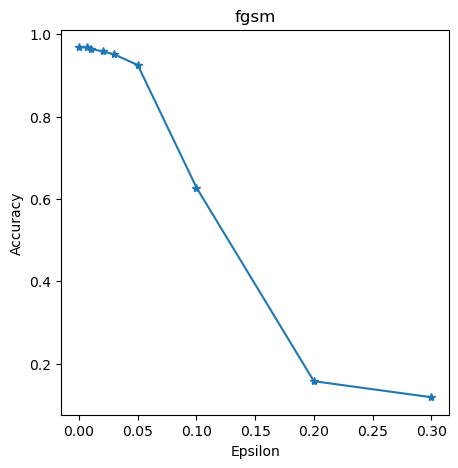

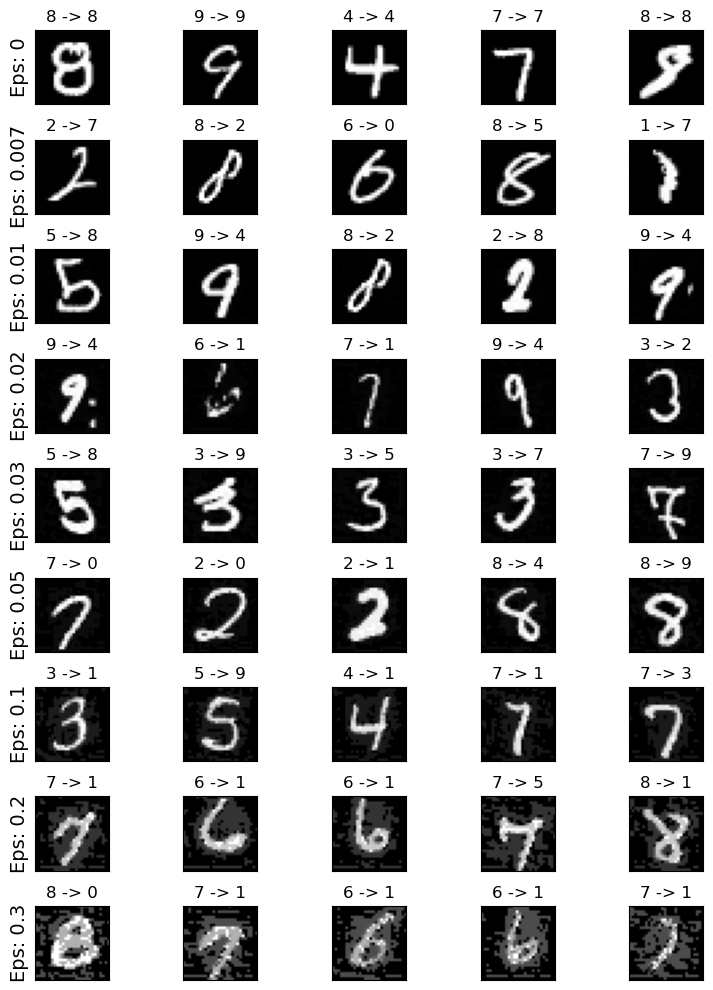

Epsilon: 0	Test Accuracy = 9700 / 10000 = 0.97
Epsilon: 0.007	Test Accuracy = 9684 / 10000 = 0.9684
Epsilon: 0.01	Test Accuracy = 9666 / 10000 = 0.9666
Epsilon: 0.02	Test Accuracy = 9625 / 10000 = 0.9625
Epsilon: 0.03	Test Accuracy = 9573 / 10000 = 0.9573
Epsilon: 0.05	Test Accuracy = 9325 / 10000 = 0.9325
Epsilon: 0.1	Test Accuracy = 7087 / 10000 = 0.7087
Epsilon: 0.2	Test Accuracy = 1896 / 10000 = 0.1896
Epsilon: 0.3	Test Accuracy = 1220 / 10000 = 0.122


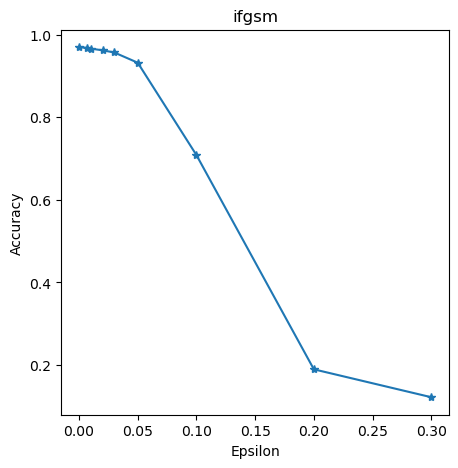

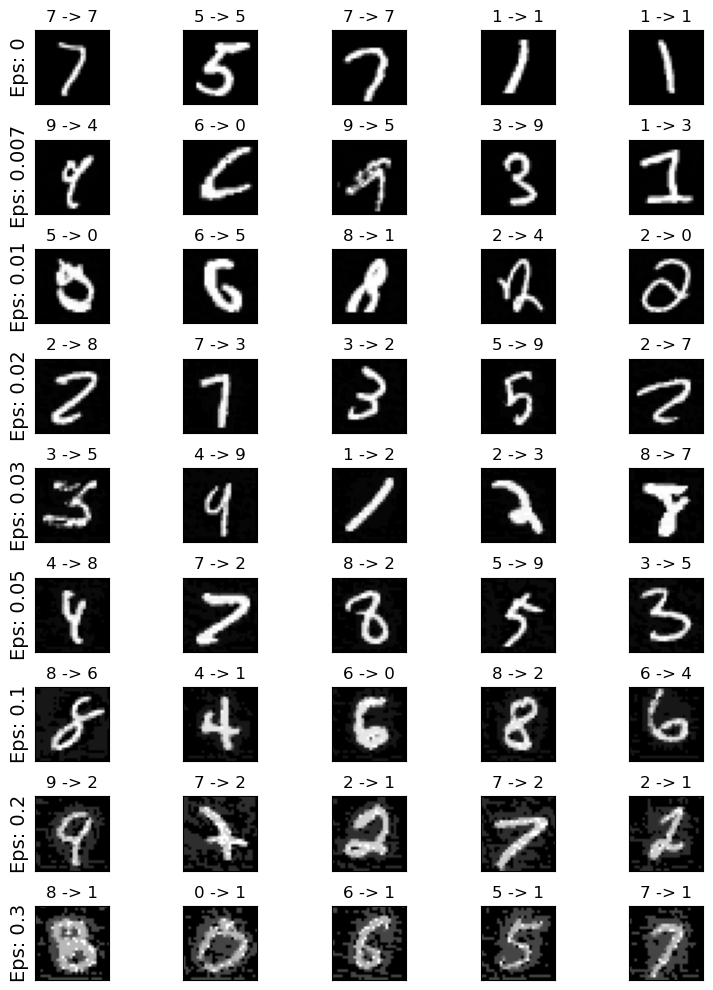

Epsilon: 0	Test Accuracy = 9672 / 10000 = 0.9672
Epsilon: 0.007	Test Accuracy = 9656 / 10000 = 0.9656
Epsilon: 0.01	Test Accuracy = 9680 / 10000 = 0.968
Epsilon: 0.02	Test Accuracy = 9594 / 10000 = 0.9594
Epsilon: 0.03	Test Accuracy = 9539 / 10000 = 0.9539
Epsilon: 0.05	Test Accuracy = 9336 / 10000 = 0.9336
Epsilon: 0.1	Test Accuracy = 7128 / 10000 = 0.7128
Epsilon: 0.2	Test Accuracy = 1914 / 10000 = 0.1914
Epsilon: 0.3	Test Accuracy = 1205 / 10000 = 0.1205


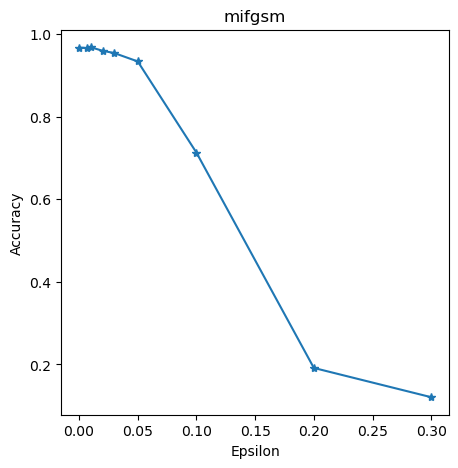

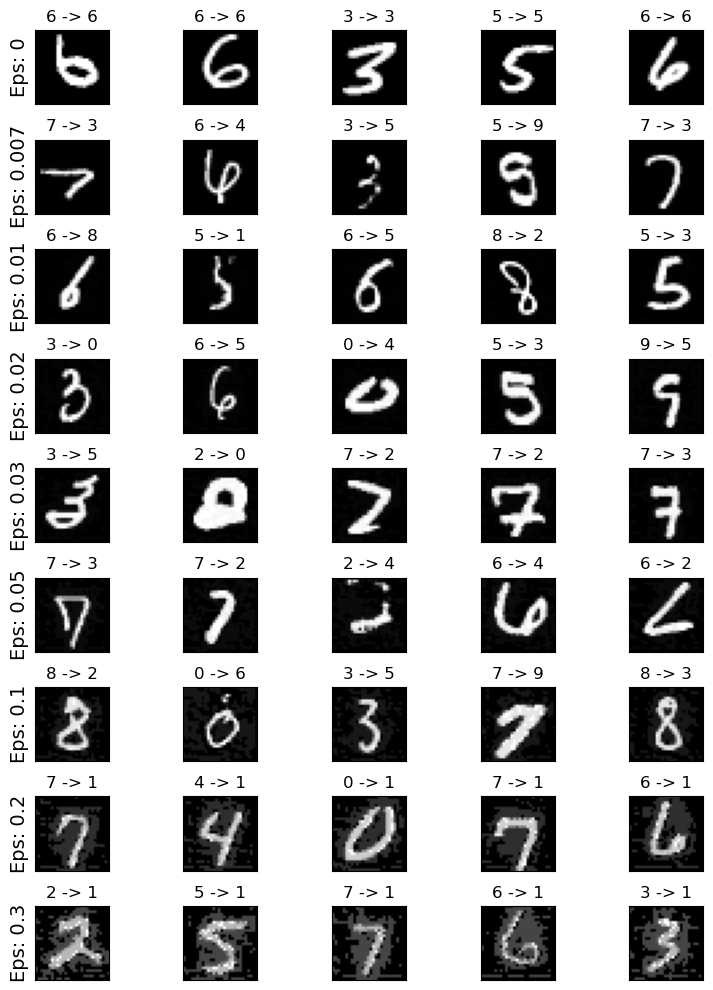

In [15]:
epsilons = [0,0.007,0.01,0.02,0.03,0.05,0.1,0.2,0.3]
for attack in ("fgsm","ifgsm","mifgsm"):
  accuracies = []
  examples = []
  for eps in epsilons:
      acc, ex = test(model, device,test_loader,eps,attack)
      accuracies.append(acc)
      examples.append(ex)
  plt.figure(figsize=(5,5))
  plt.plot(epsilons, accuracies, "*-")
  plt.title(attack)
  plt.xlabel("Epsilon")
  plt.ylabel("Accuracy")
  plt.show()

  cnt = 0
  plt.figure(figsize=(8,10))
  for i in range(len(epsilons)):
      for j in range(len(examples[i])):
          cnt += 1
          plt.subplot(len(epsilons),len(examples[0]),cnt)
          plt.xticks([], [])
          plt.yticks([], [])
          if j == 0:
              plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
          orig,adv,ex = examples[i][j]
          plt.title("{} -> {}".format(orig, adv))
          plt.imshow(ex, cmap="gray")
  plt.tight_layout()
  plt.show()

# # Defense

In [21]:
class NetF(nn.Module):
  def __init__(self):
    super(NetF, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, 3, 1)
    self.conv2 = nn.Conv2d(32, 64, 3, 1)
    self.dropout1 = nn.Dropout(0.25)
    self.dropout2 = nn.Dropout(0.5)
    self.fc1 = nn.Linear(9216, 128)
    self.fc2 = nn.Linear(128, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = self.dropout1(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dropout2(x)
    x = self.fc2(x)
    return x

class NetF1(nn.Module):
  def __init__(self):
    super(NetF1, self).__init__()
    self.conv1 = nn.Conv2d(1, 16, 3, 1)
    self.conv2 = nn.Conv2d(16, 32, 3, 1)
    self.dropout1 = nn.Dropout(0.25)
    self.dropout2 = nn.Dropout(0.5)
    self.fc1 = nn.Linear(4608, 64)
    self.fc2 = nn.Linear(64, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = self.dropout1(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dropout2(x)
    x = self.fc2(x)
    return x

In [22]:
def fgsm_attack(input,epsilon,data_grad):
  pert_out = input + epsilon*data_grad.sign()
  pert_out = torch.clamp(pert_out, 0, 1)
  return pert_out

def ifgsm_attack(input,epsilon,data_grad):
  iter = 10
  alpha = epsilon/iter
  pert_out = input
  for i in range(iter-1):
    pert_out = pert_out + alpha*data_grad.sign()
    pert_out = torch.clamp(pert_out, 0, 1)
    if torch.norm((pert_out-input),p=float('inf')) > epsilon:
      break
  return pert_out

def mifgsm_attack(input,epsilon,data_grad):
  iter=10
  decay_factor=1.0
  alpha = epsilon/iter
  pert_out = input
  g=0
  for i in range(iter-1):
    g = decay_factor*g + data_grad/torch.norm(data_grad,p=1)
    pert_out = pert_out + alpha*torch.sign(g)
    pert_out = torch.clamp(pert_out, 0, 1)
    if torch.norm((pert_out-input),p=float('inf')) > epsilon:
      break
  return pert_out

In [23]:
def fit(model,device,optimizer,scheduler,criterion,train_loader,val_loader,Temp,epochs):
  data_loader = {'train':train_loader,'val':val_loader}
  print("Fitting the model...")
  train_loss,val_loss=[],[]
  for epoch in range(epochs):
    loss_per_epoch,val_loss_per_epoch=0,0
    for phase in ('train','val'):
      for i,data in enumerate(data_loader[phase]):
        input,label  = data[0].to(device),data[1].to(device)
        output = model(input)
        output = F.log_softmax(output/Temp,dim=1)
        #calculating loss on the output
        loss = criterion(output,label)
        if phase == 'train':
          optimizer.zero_grad()
          #grad calc w.r.t Loss func
          loss.backward()
          #update weights
          optimizer.step()
          loss_per_epoch+=loss.item()
        else:
          val_loss_per_epoch+=loss.item()
    scheduler.step(val_loss_per_epoch/len(val_loader))
    print("Epoch: {} Loss: {} Val_Loss: {}".format(epoch+1,loss_per_epoch/len(train_loader),val_loss_per_epoch/len(val_loader)))
    train_loss.append(loss_per_epoch/len(train_loader))
    val_loss.append(val_loss_per_epoch/len(val_loader))
  return train_loss,val_loss

def test(model,device,test_loader,epsilon,Temp,attack):
  correct=0
  adv_examples = []
  for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    data.requires_grad = True
    output = model(data)
    output = F.log_softmax(output/Temp,dim=1)
    init_pred = output.max(1, keepdim=True)[1] 
    if init_pred.item() != target.item():
        continue
    loss = F.nll_loss(output, target)
    model.zero_grad()
    loss.backward()
    data_grad = data.grad.data

    if attack == "fgsm":
      perturbed_data = fgsm_attack(data,epsilon,data_grad)
    elif attack == "ifgsm":
      perturbed_data = ifgsm_attack(data,epsilon,data_grad)
    elif attack == "mifgsm":
      perturbed_data = mifgsm_attack(data,epsilon,data_grad)
      
    output = model(perturbed_data)
    final_pred = output.max(1, keepdim=True)[1]
    if final_pred.item() == target.item():
        correct += 1
        if (epsilon == 0) and (len(adv_examples) < 5):
            adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
            adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
    else:
        if len(adv_examples) < 5:
            adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
            adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

  final_acc = correct/float(len(test_loader))
  print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

  return final_acc,adv_examples

In [24]:
def defense(device,train_loader,val_loader,test_loader,epochs,Temp,epsilons):

  modelF = NetF().to(device)
  optimizerF = optim.Adam(modelF.parameters(),lr=0.0001, betas=(0.9, 0.999))
  schedulerF = optim.lr_scheduler.ReduceLROnPlateau(optimizerF, mode='min', factor=0.1, patience=3)

  modelF1 = NetF1().to(device)
  optimizerF1 = optim.Adam(modelF1.parameters(),lr=0.0001, betas=(0.9, 0.999))
  schedulerF1 = optim.lr_scheduler.ReduceLROnPlateau(optimizerF1, mode='min', factor=0.1, patience=3)

  criterion = nn.NLLLoss()

  lossF,val_lossF=fit(modelF,device,optimizerF,schedulerF,criterion,train_loader,val_loader,Temp,epochs)
  fig = plt.figure(figsize=(5,5))
  plt.plot(np.arange(1,epochs+1), lossF, "*-",label="Loss")
  plt.plot(np.arange(1,epochs+1), val_lossF,"o-",label="Val Loss")
  plt.title("Network F")
  plt.xlabel("Num of epochs")
  plt.legend()
  plt.show()

  #converting target labels to soft labels
  for data in train_loader:
    input, label  = data[0].to(device),data[1].to(device)
    softlabel  = F.log_softmax(modelF(input),dim=1)
    data[1] = softlabel

  lossF1,val_lossF1=fit(modelF1,device,optimizerF1,schedulerF1,criterion,train_loader,val_loader,Temp,epochs)
  fig = plt.figure(figsize=(5,5))
  plt.plot(np.arange(1,epochs+1), lossF1, "*-",label="Loss")
  plt.plot(np.arange(1,epochs+1), val_lossF1,"o-",label="Val Loss")
  plt.title("Network F'")
  plt.xlabel("Num of epochs")
  plt.legend()
  plt.show()

  model = NetF1().to(device)
  model.load_state_dict(modelF1.state_dict())
  for attack in ("fgsm","ifgsm","mifgsm"):
    accuracies = []
    examples = []
    for eps in epsilons:
        acc, ex = test(model,device,test_loader,eps,1,"fgsm")
        accuracies.append(acc)
        examples.append(ex)
    
    plt.figure(figsize=(5,5))
    plt.plot(epsilons, accuracies, "*-")
    plt.title(attack)
    plt.xlabel("Epsilon")
    plt.ylabel("Accuracy")
    plt.show()

    cnt = 0
    plt.figure(figsize=(8,10))
    for i in range(len(epsilons)):
        for j in range(len(examples[i])):
            cnt += 1
            plt.subplot(len(epsilons),len(examples[0]),cnt)
            plt.xticks([], [])
            plt.yticks([], [])
            if j == 0:
                plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
            orig,adv,ex = examples[i][j]
            plt.title("{} -> {}".format(orig, adv))
            plt.imshow(ex, cmap="gray")
    plt.tight_layout()
    plt.show()

Fitting the model...
Epoch: 1 Loss: 0.5520574264198342 Val_Loss: 0.4026320323681472
Epoch: 2 Loss: 0.30855217951337277 Val_Loss: 0.25579376456656083
Epoch: 3 Loss: 0.21256353778605888 Val_Loss: 0.1887488047729963
Epoch: 4 Loss: 0.15973845125682365 Val_Loss: 0.1588749119235324
Epoch: 5 Loss: 0.13392584946629685 Val_Loss: 0.1381914706620783
Epoch: 6 Loss: 0.11417759636177884 Val_Loss: 0.12412559311918527
Epoch: 7 Loss: 0.10673835434324665 Val_Loss: 0.11779394155791165
Epoch: 8 Loss: 0.09586714070366735 Val_Loss: 0.10741431933348772
Epoch: 9 Loss: 0.09347887324100278 Val_Loss: 0.10843706820384084
Epoch: 10 Loss: 0.0899432256852209 Val_Loss: 0.10647166650161106


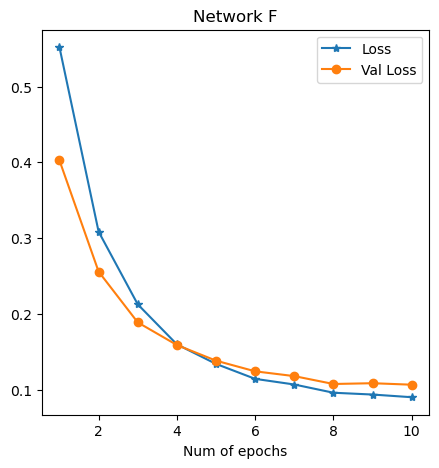

Fitting the model...
Epoch: 1 Loss: 0.6981186343112039 Val_Loss: 0.5367033026842126
Epoch: 2 Loss: 0.4681453322743436 Val_Loss: 0.4523972527890438
Epoch: 3 Loss: 0.4226020986373446 Val_Loss: 0.41788251844656626
Epoch: 4 Loss: 0.3643009932048316 Val_Loss: 0.34369809060561063
Epoch: 5 Loss: 0.3079084817576919 Val_Loss: 0.2922704053071131
Epoch: 6 Loss: 0.25165289885658604 Val_Loss: 0.25608295188300356
Epoch: 7 Loss: 0.2165434669897284 Val_Loss: 0.20958867769638864
Epoch: 8 Loss: 0.18725775087647983 Val_Loss: 0.20034304955662377
Epoch: 9 Loss: 0.16675716198476043 Val_Loss: 0.18310904020612181
Epoch: 10 Loss: 0.15679034477975753 Val_Loss: 0.16893884398933243


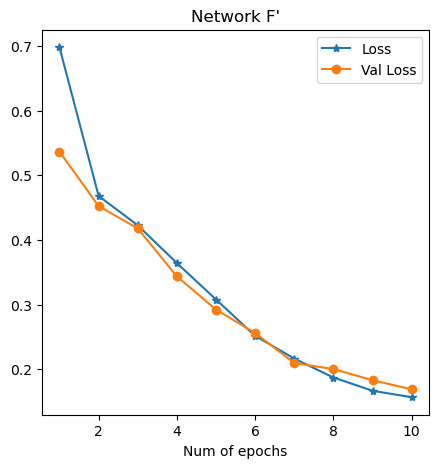

Epsilon: 0	Test Accuracy = 9373 / 10000 = 0.9373
Epsilon: 0.007	Test Accuracy = 9291 / 10000 = 0.9291
Epsilon: 0.01	Test Accuracy = 9338 / 10000 = 0.9338
Epsilon: 0.02	Test Accuracy = 9362 / 10000 = 0.9362
Epsilon: 0.03	Test Accuracy = 9291 / 10000 = 0.9291
Epsilon: 0.05	Test Accuracy = 9279 / 10000 = 0.9279
Epsilon: 0.1	Test Accuracy = 9281 / 10000 = 0.9281
Epsilon: 0.2	Test Accuracy = 9216 / 10000 = 0.9216
Epsilon: 0.3	Test Accuracy = 9191 / 10000 = 0.9191


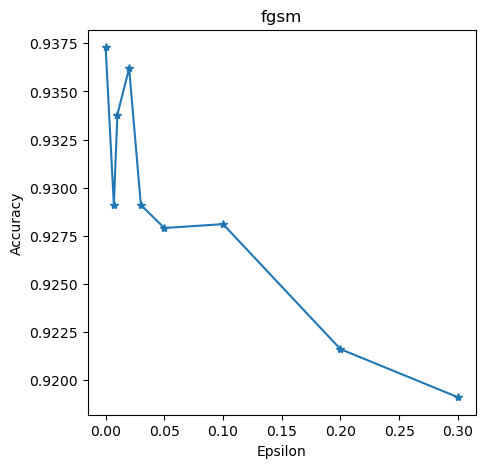

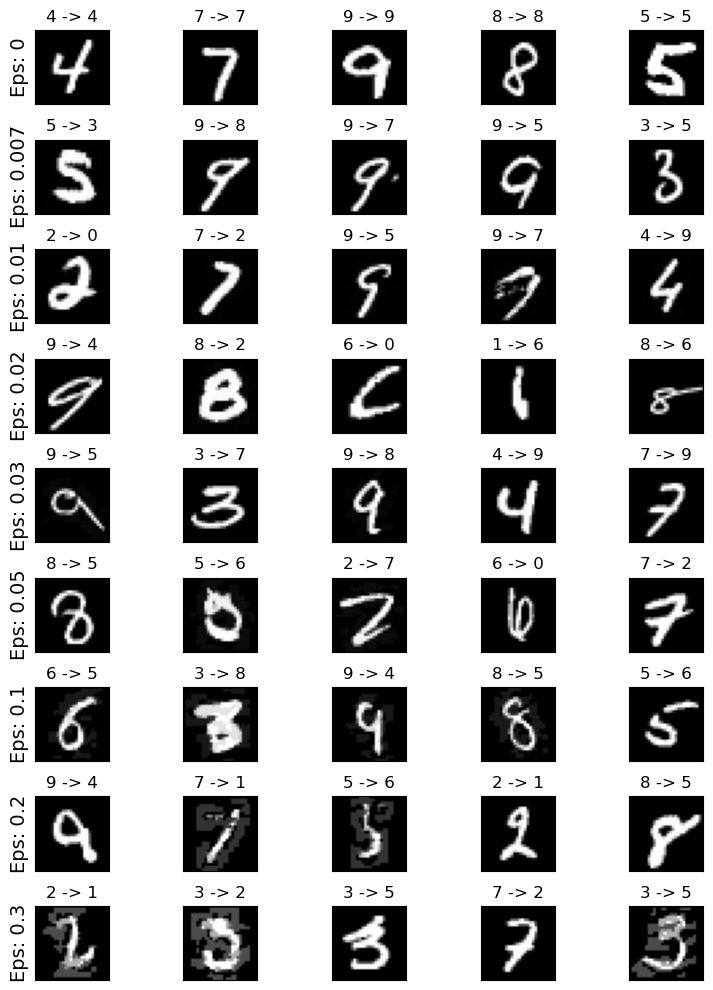

Epsilon: 0	Test Accuracy = 9358 / 10000 = 0.9358
Epsilon: 0.007	Test Accuracy = 9336 / 10000 = 0.9336
Epsilon: 0.01	Test Accuracy = 9314 / 10000 = 0.9314
Epsilon: 0.02	Test Accuracy = 9323 / 10000 = 0.9323
Epsilon: 0.03	Test Accuracy = 9361 / 10000 = 0.9361
Epsilon: 0.05	Test Accuracy = 9336 / 10000 = 0.9336
Epsilon: 0.1	Test Accuracy = 9249 / 10000 = 0.9249
Epsilon: 0.2	Test Accuracy = 9206 / 10000 = 0.9206
Epsilon: 0.3	Test Accuracy = 9181 / 10000 = 0.9181


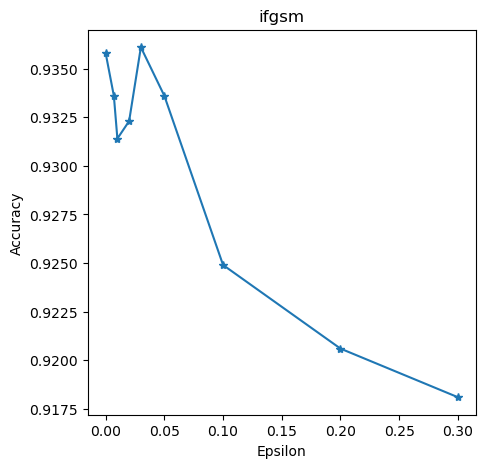

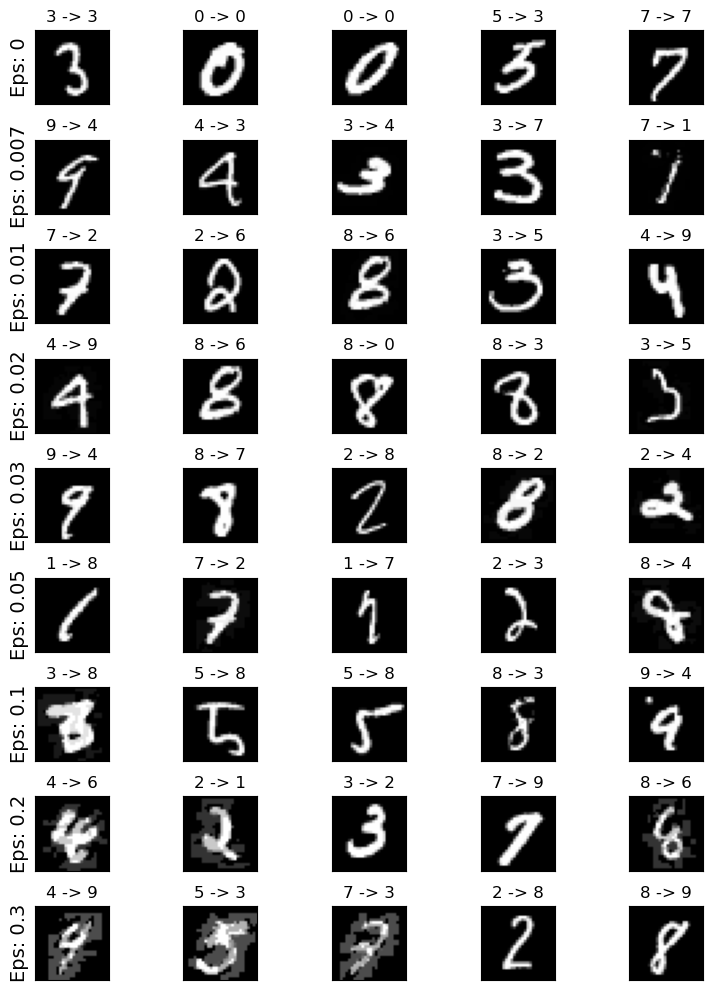

Epsilon: 0	Test Accuracy = 9348 / 10000 = 0.9348
Epsilon: 0.007	Test Accuracy = 9344 / 10000 = 0.9344
Epsilon: 0.01	Test Accuracy = 9333 / 10000 = 0.9333
Epsilon: 0.02	Test Accuracy = 9352 / 10000 = 0.9352
Epsilon: 0.03	Test Accuracy = 9336 / 10000 = 0.9336
Epsilon: 0.05	Test Accuracy = 9305 / 10000 = 0.9305
Epsilon: 0.1	Test Accuracy = 9230 / 10000 = 0.923
Epsilon: 0.2	Test Accuracy = 9196 / 10000 = 0.9196
Epsilon: 0.3	Test Accuracy = 9148 / 10000 = 0.9148


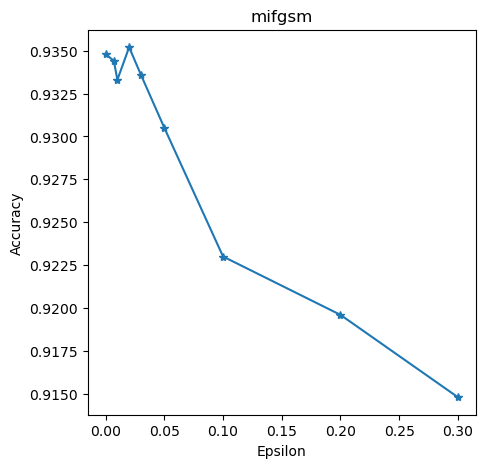

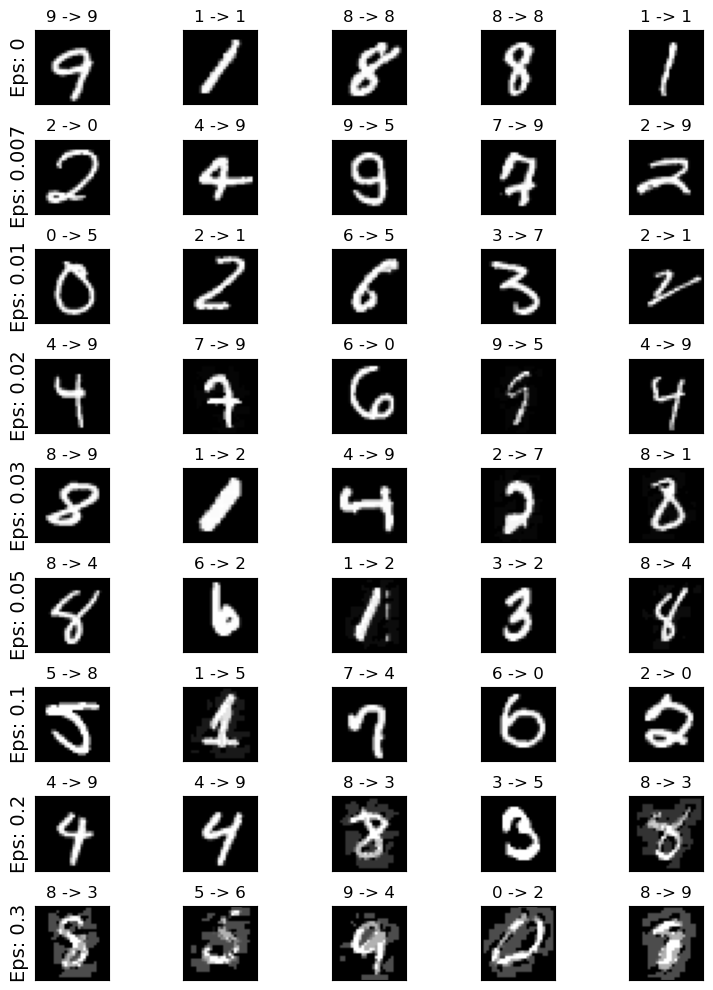

In [25]:
Temp=100
epochs=10
epsilons=[0,0.007,0.01,0.02,0.03,0.05,0.1,0.2,0.3]
defense(device,train_loader,val_loader,test_loader,epochs,Temp,epsilons)